# PCA: Invariant risk metrics and representation of residuals for bond returns

Diego Alvarez, diego.alvarez@colorado.edu

# Packages

In [1]:
import pulp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Background

Throughout this model we will use 3 different sets of term structures <br>
1. Generic US Treasury Yield
2. USD Swap Curve ($\Delta$)
3. USD Swaption Straddles ($\Gamma$)

# Load and Prep Dataa

In [2]:
df = (pd.read_parquet(
    "rates_data.parquet").
    dropna().
    assign(ticker = lambda x: x.ticker.str.split(" ").str[0]))

(df.drop(
    columns = ["source", "sec_type"]).
    pivot(index = "date", columns = "ticker", values = "value").
    dropna().
    head(3))

ticker,DGS1,DGS10,DGS1MO,DGS2,DGS20,DGS3,DGS3MO,DGS5,DGS7,USSO1,...,USSOK,USSVAA01,USSVAA03,USSVAA04,USSVAA05,USSVAA07,USSVAA10,USSVAA15,USSVAA20,USSVAA30
date,,,,,,,,,,,,,,,,,,,,,
2021-05-04,0.06,1.61,0.01,0.16,2.16,0.33,0.02,0.82,1.28,0.0901,...,0.0890,0.2110,0.492,0.7295,0.951,1.299,1.609,1.864,1.9650,2.011
2021-05-05,0.06,1.59,0.01,0.16,2.14,0.32,0.02,0.80,1.25,0.0865,...,0.0856,0.2050,0.484,0.7180,0.929,1.280,1.590,1.847,1.9520,1.997
2021-05-06,0.05,1.58,0.01,0.16,2.14,0.32,0.02,0.81,1.25,0.0861,...,0.0850,0.1985,0.478,0.7140,0.924,1.266,1.575,1.831,1.9335,1.981


Examining how much data is collected

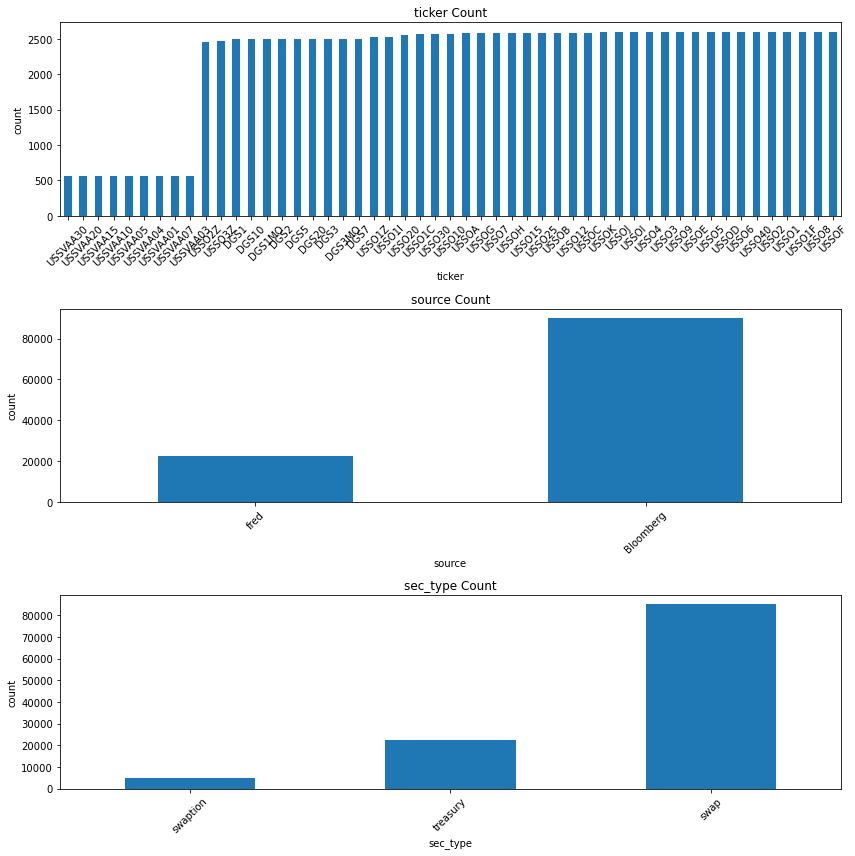

In [3]:
groupby_col = ["ticker", "source", "sec_type"]
fig, axes = plt.subplots(nrows = 3, figsize = (12, 12))

for i, col in enumerate(groupby_col):
    
    (df[
        ["value", col]].
        groupby(col).
        agg("count").
        sort_values("value").
        plot(
            ax = axes[i],
            kind = "bar",
            legend = False,
            title = "{} Count".format(col),
            rot = 45,
            ylabel = "count"))
    
plt.tight_layout()

Looking at first and last dates

In [4]:
(df[
    ["date", "ticker"]].
    groupby("ticker").
    agg(["min", "max"])
    ["date"].
    head())

,min,max
ticker,,
DGS1,2013-08-23,2023-08-22
DGS10,2013-08-23,2023-08-22
DGS1MO,2013-08-23,2023-08-22
DGS2,2013-08-23,2023-08-22
DGS20,2013-08-23,2023-08-22


# EDA & Data Cleaning

We need to add in tenors. There is a tenor csv file that we can just join

In [5]:
tenors = (pd.read_csv(
    "tenors.csv")
    [["ticker", "maturity"]])

df_tenors = (df.merge(
    right = tenors, how = "outer", on = ["ticker"]))

Let's just generate some sample curves from the data using random dates

In [6]:
np.random.seed(1234)
random_dates = list(np.random.choice(df.query("sec_type == 'swaption'").date.drop_duplicates(), 3))

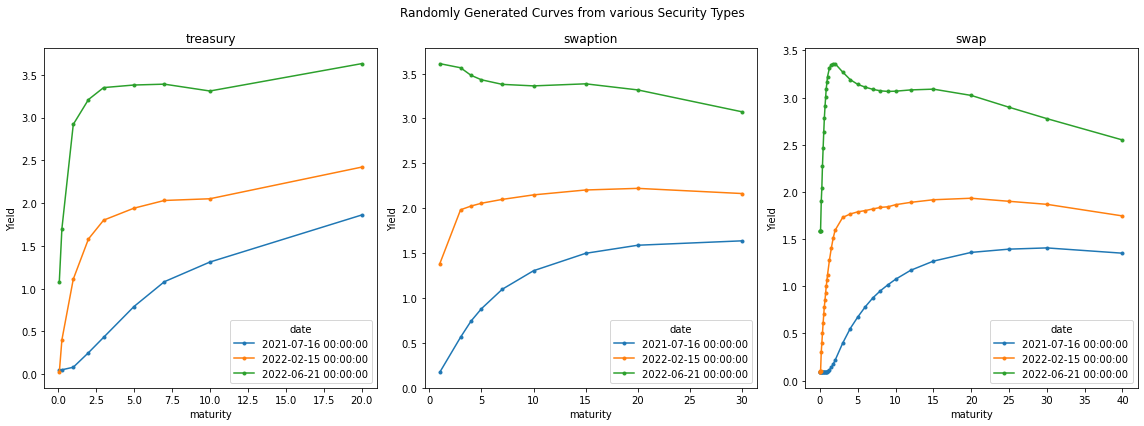

In [7]:
df_plot = (df_tenors.query(
    "date == @random_dates").
    drop(columns = ["source", "ticker"]))

sec_types = df_plot.sec_type.drop_duplicates()
fig, axes = plt.subplots(ncols = len(sec_types), figsize = (16, 6))

for i, sec_type in enumerate(sec_types):
    
    (df_plot.query(
        "sec_type == @sec_type").
        drop(columns = ["sec_type"]).
        pivot(index = "maturity", columns = "date", values = "value").
        plot(
            ax = axes[i],
            style = ".-",
            ylabel = "Yield",
            title = sec_type))
    
plt.suptitle("Randomly Generated Curves from various Security Types")
plt.tight_layout()
plt.show()

# Initial Motivation

The application of Principal Component Analysis is a commonplace method used to decompose yield curve or any term structure, and is the basis for most curve base trading. The ability to segregate different movements of various term structures can provide outlook as well as trading activities. PC (Principal Components) are commonly used on many buy-side and sell-side desks. The PCs also lend themsleves useful because they have economically interpretable meanings and analog tradedable security counterparts. 

Start by de-trending the data

In [8]:
def de_trend(df: pd.DataFrame) -> pd.DataFrame:
    return(df.sort_values(
        "date").
        assign(value = lambda x: x.value - x.value.shift(1)))

df_detrend = (df.drop(
    columns = ["source"]).
    groupby(["sec_type", "ticker"]).
    apply(de_trend))

Start by analyzing yield curve PCs

In [9]:
def _make_pca_model(df: pd.DataFrame, NCOMPONENTS: int = 3) -> pd.DataFrame:
    
    pca = PCA(n_components = NCOMPONENTS)
    df_longer = (df.drop(
            columns = ["sec_type"]).
            pivot(index = "date", columns = "ticker", values = "value").
            dropna())
    
    pca_fit = pca.fit(df_longer)
    explained_variance_ratio = pca_fit.explained_variance_ratio_
    pca_transform = pca.fit_transform(df_longer)
    
    cols = ["comp{}".format(i + 1) for i in range(NCOMPONENTS)]
    
    df_explain = (pd.DataFrame({
        "variable": cols,
        "value": explained_variance_ratio}).
        assign(data_type = "variance"))
    
    df_fitted = (pd.DataFrame(
        data = pca_transform,
        columns = cols).
        assign(date = df_longer.index).
        melt(id_vars = "date").
        assign(data_type = "fitted_value"))
    
    return(pd.concat(
        [df_fitted, df_explain]))

df_pca_results = (df_detrend.groupby(
    "sec_type").
    apply(_make_pca_model).
    reset_index().
    drop(columns = ["level_1"]))

Analyzing the results

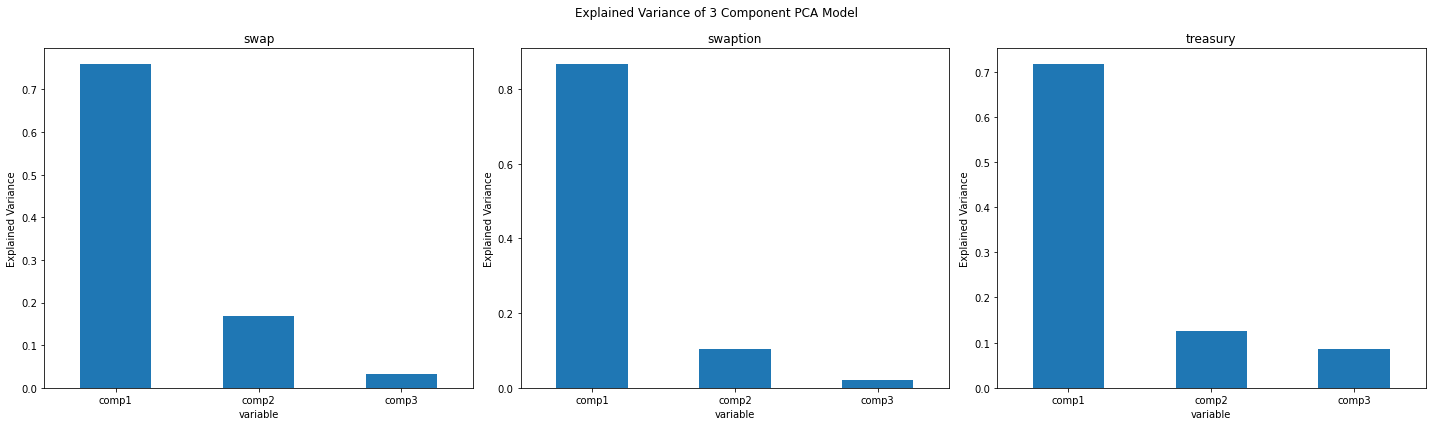

In [10]:
df_exp = (df_pca_results.query(
    "data_type == 'variance'").
    drop(columns = ["data_type", "date"]).
    pivot(index = "variable", columns = "sec_type", values = "value"))

cols = df_exp.columns.to_list()
fig, axes = plt.subplots(ncols = len(cols), figsize = (20,6))
for i, col in enumerate(cols):
    
    (df_exp[
        col].
        plot(
            ax = axes[i],
            kind = "bar",
            title = col,
            ylabel = "Explained Variance",
            rot = 360))
    
fig.suptitle("Explained Variance of 3 Component PCA Model")
plt.tight_layout()
plt.show()

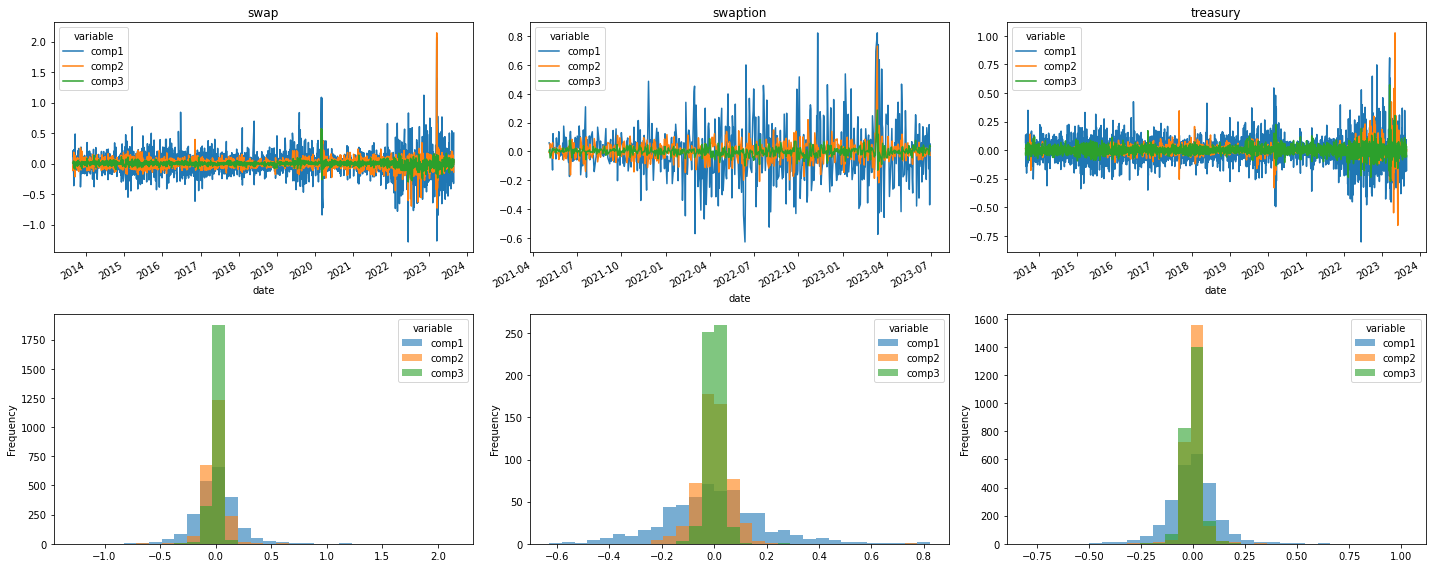

In [11]:
df_fitted = (df_pca_results.query(
    "data_type == 'fitted_value'").
    drop(columns = ["data_type"]).
    pivot(index = "date", columns = ["sec_type", "variable"], values = "value"))

cols = df_fitted.columns.swaplevel(0,1).droplevel().drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(cols), nrows = 2, figsize = (20, 8))

for i, col in enumerate(cols):
    
    (df_fitted[
        col].
        dropna().
        plot(
            ax = axes[0,i],
            title = col))
    
    (df_fitted[
        col].
        dropna().
        plot(
            kind = "hist",
            ax = axes[1,i],
            bins = 30,
            alpha = 0.6))
    
plt.tight_layout()
plt.show()

# Mathematical Background

If we begin a with a portfolio containing solely linear ($\Delta$) products by the standard reduced PCA form of the Singular Value Decomposition we get the following <br>
\begin{equation}Y = U \Sigma V^T \rightarrow Y = \hat{U} \hat{\Sigma}V^T \; m\; components \end{equation}<br>
If we have a portflio's daily change $\Delta P$ taking the form <br>
\begin{equation}\Delta P = \sqrt{m}\hat{U}J \end{equation}

We can find its variance <br>
\begin{equation}
\begin{split}
\frac{(\Delta P)^T (\Delta P)}{m} &= J^T \hat{U}^T \hat{U}J\\
&=||J||_2^2
\end{split}
\end{equation}

The problem at hand is that this only captures realized linear processes while working with convex instruments which exhibit non-linear processes. <br>
Therefore we can define the change in portfolio $\Delta \Pi$ as the change in the linear processes played-back over the first derivative, which should capture $\Delta$ greek and then the second derivative which should capture the $\Gamma$ greek. In this case we model each derivative with a coefficient $\alpha$ assumed to $\sim N(0,1)$

\begin{equation}
\Delta \Pi = J^T \alpha + \frac{1}{2} \alpha^T H \alpha
\end{equation}
where 
\begin{equation}
H_{ij} = \frac{\partial^2 \Pi}{\partial PC_i \partial PC_j}
\end{equation}
And thus the explained variance can be defined as 
\begin{equation}
\mathbb{E}(\Delta \Pi^2) = \left( \frac{\partial \Pi}{\partial PC_1} \right)^2 + \left( \frac{\partial \Pi}{\partial PC_2} \right)^2 + \left( \left( \frac{\partial^2 \Pi}{\partial PC_1^2} \right)^2 + \left( \frac{\partial^2 \Pi}{\partial PC_2^2} \right)^2\right) + \frac{1}{4} \left( \frac{\partial^2 \Pi}{\partial PC_1^2} + \frac{\partial^2 \Pi}{\partial PC_2^2} \right)
\end{equation}
Although its apparent that we've have a scaling problem when expanding to higher PCs which would lead to definite computational complexity bottlenecks the overall goal is to model the first 2 components therefore capping the number of terms we are working with

# Creating Flylets

Recall that the overall goal is to create these flylets which are sort-of 3rd PC proxies. From an economical standpoint the 3rd PC which measures bellying (convexity) of the yield curve (or any curve in this case). The authors choose to make the flylets in the form of using 3 conesecutive tenors like a standard yield curve fly but optimize with weights with respect to original PCs. The mathematical definition for the $i$th flylet is 
\begin{equation}
\vec{f}_i = \left(0_{(i-2)}, a_i, b_1, c_1, 0_{(n-i-1)} \right)
\end{equation}
And therefore maintain orthogonality to the first PCs 
\begin{equation}
\vec{f}_i \cdot PC_1 = \vec{f}_i \cdot PC_2 = 0
\end{equation}
And have weights summing to 1.
\begin{equation}
||f_i||_2^2 = 1
\end{equation}

My approach was pretty simple. My overall goal is knowing that the first 2 pcs are orthogonal, I can take the cross product of them and find an orthogonal vector to each PC respectively. Since I'm zeroing out all indices that aren't related to the specific flylet ($i-1, i, i+1$) I'm really finding an orthogonal vector to a 3 dimensional PC1 and PC2 vector since the rest will be zeroed out. I've also discovered that the NumPy cross method only expects vectors of 2 or 3 dimensions which lucked out. I take the cross products and then 0 out the rest of the vectors. It seems that its not guaranteed for the weights to be (-,+,-). When I force the vector to have that sign scheme it appears that I still keep orthogonality and the vector norm space condition. I've writen some functions to double check these conditions.

In [12]:
def _clean_flylets(weights: np.array, cols: list) -> pd.DataFrame:
    return(pd.DataFrame(
        data = weights,
        columns = cols).
        reset_index().
        assign(index = lambda x: "flylet" + (x.index + 1).astype(str)).
        melt(id_vars = "index").
        query("value != 0").
        sort_values("index"))

def _prep_pc_weight(
    pc: np.array,
    cols: list,
    pc_name: str) -> pd.DataFrame:
    return(pd.DataFrame({
        "value": pc,
        "variable": cols}).
        assign(
            flylet = pc_name,
            weight = "eigenvector"))
    
def get_flylets(df: pd.DataFrame):
    
    df_longer = (df.drop(
        columns = ["sec_type"]).
        pivot(index = "date", columns = "maturity", values = "value").
        dropna())
    
    df_matrix = (df_longer.reset_index(
        drop = True).
        to_numpy())
    
    pca = PCA(n_components = 2)
    pca_fit = pca.fit(df_matrix)
    eigenvectors = pca_fit.components_
    pc1, pc2 = eigenvectors[0], eigenvectors[1]
    
    weights1, weights2 = np.array([]), np.array([])
    for i in range(1,len(pc1)-1):
    
        orthogonal_vector = np.cross(pc1[i-1:i+2], pc2[i-1:i+2])

        front_vector = np.zeros(i-1)
        back_vector = np.zeros(len(pc1) - len(orthogonal_vector) - i + 1)
        orthogonal_vector = np.concatenate((front_vector, orthogonal_vector, back_vector))

        orthogonal_vector /= np.linalg.norm(orthogonal_vector)

        try: weights1 = np.vstack([weights1, orthogonal_vector])
        except: weights1 = orthogonal_vector
        
        orthogonal_vector = np.abs(orthogonal_vector)
        orthogonal_vector[i-1] = -orthogonal_vector[i-1]
        orthogonal_vector[i] = orthogonal_vector[i]
        orthogonal_vector[i+1] = -orthogonal_vector[i+1]

        try: weights2 = np.vstack([weights2, orthogonal_vector])
        except: weights2 = orthogonal_vector
      
    cols = df_longer.columns.to_list()
    df_weights = (pd.concat([
        _clean_flylets(weights1, cols).assign(weight = "orthogonal"), 
        _clean_flylets(weights2, cols).assign(weight = "fly_weights")]).
        rename(columns = {
            "index": "flylet"}))
    
    pc_weights = (pd.concat([
        _prep_pc_weight(pc1, cols, "PC1"),
        _prep_pc_weight(pc2, cols, "PC2")]))
    
    df_out = pd.concat([df_weights, pc_weights])
    return(df_out)
    
df_flylets = (df_detrend.merge(
    right = tenors, how = "outer", on = ["ticker"]).
    drop(columns = ["ticker"]).
    groupby("sec_type").
    apply(get_flylets).
    reset_index().
    drop(columns = ["level_1"]))

# Checking Flylet Results

Functions to confirm they hold their statistical and linear algebra properties

In [13]:
def _check_orthogonal(df: pd.DataFrame) -> pd.DataFrame:
    
    weight_list = df.weight.drop_duplicates().to_list()
    weight_list.remove("eigenvector")
    weight = weight_list[0]
    
    df_wider = (df.drop(
        columns = ["weight"]).
        pivot(index = "variable", columns = "flylet", values = "value").
        fillna(0))
    
    flylets_cols = (df_wider.T.reset_index().query(
        "flylet != ['PC1', 'PC2']")
        ["flylet"].
        to_list())
    PC1, PC2, flylets = df_wider[["PC1"]], df_wider[["PC2"]], df_wider[flylets_cols]

    df_ortho = (pd.DataFrame(
        data = {
            "PC1_ortho": np.dot(flylets.T, PC1).squeeze(),
            "PC2_ortho": np.dot(flylets.T, PC2).squeeze(),
            "flylet": flylets.columns.to_list()}).
        assign(flylet = lambda x: x.flylet.str.replace("flylet", "").astype(int)).
        set_index("flylet").
        sort_index().
        reset_index().
        melt(id_vars = "flylet").
        assign(weight = weight))
    
    return df_ortho
    
def check_orthogonal(df: pd.DataFrame) -> pd.DataFrame:
    
    df_eigen_weights = (df.drop(
        columns = ["sec_type"]).
        query("weight == ['orthogonal', 'eigenvector']"))
    
    df_fly_weights = (df.drop(
        columns = ["sec_type"]).
        query("weight == ['fly_weights', 'eigenvector']"))
    
    df_out = pd.concat([
        _check_orthogonal(df_eigen_weights),
        _check_orthogonal(df_fly_weights)])
    
    return(df_out)

def plot_ortho_check(df: pd.DataFrame) -> plt.subplot:
    
    df_ortho_check = (df.groupby(
        "sec_type").
        apply(check_orthogonal).
        reset_index().
        drop(columns = ["level_1"]))
    
    sec_types = df_ortho_check.sec_type.drop_duplicates().to_list()
    weight_types = df_ortho_check.weight.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(sec_types), nrows = len(weight_types), figsize = (25, 10))

    for i, sec_type in enumerate(sec_types):
        for j, weight in enumerate(weight_types):

            df_plot = (df_ortho_check.query(
                "sec_type == @sec_type & weight == @weight").
                drop(columns = ["sec_type", "weight"]).
                pivot(index = "flylet", columns = "variable", values = "value").
                rename(columns = {
                    "PC1_ortho": "PC1",
                    "PC2_ortho": "PC2"}))

            (df_plot.plot(
                ax = axes[j,i],
                kind = "bar",
                ylabel = "Orthogonal Value",
                title = "Measure of Orthogonality of Flylet Weights\nSecurity Type: {}, Method Type: {}".format(
                    sec_type, weight)))
            
    fig.suptitle("Measure of Orthogonality")

In [18]:
def _check_norm(df: pd.DataFrame) -> pd.DataFrame:
    
    df_tmp = (df.drop(
        columns = ["sec_type", "weight"]).
        pivot(index = "flylet", columns = "variable", values = "value").
        fillna(0))
    
    df_check = (df_tmp ** 2).sum(axis = 1).to_frame(name = "summed_weights")
    return(df_check)

def check_norm(df: pd.DataFrame) -> pd.DataFrame:

    return(df.query(
        "weight != 'eigenvector'").
        groupby(["sec_type", "weight"]).
        apply(_check_norm).
        reset_index().
        assign(flylet = lambda x: x.flylet.str.replace("flylet", "").astype(int)))

In [19]:
def plot_check_norm(df: pd.DataFrame) -> plt.Subplot:
    
    df_check_norm = check_norm(df)
    
    sec_types = df_check_norm.sec_type.drop_duplicates().to_list()
    weight_types = df_check_norm.weight.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(sec_types), nrows = len(weight_types), figsize = (25, 10))

    for i, sec_type in enumerate(sec_types):
        for j, weight in enumerate(weight_types):

            (df_check_norm.query(
                "sec_type == @sec_type & weight == @weight").
                set_index("flylet")
                [["summed_weights"]].
                sort_index().
                plot(
                    ax = axes[j,i],
                    kind = "bar",
                    legend = False,
                    ylabel = "Summed Square Weights",
                    title = "Sec Type: {} Weight Type: {}".format(
                        sec_type, weight)))
            


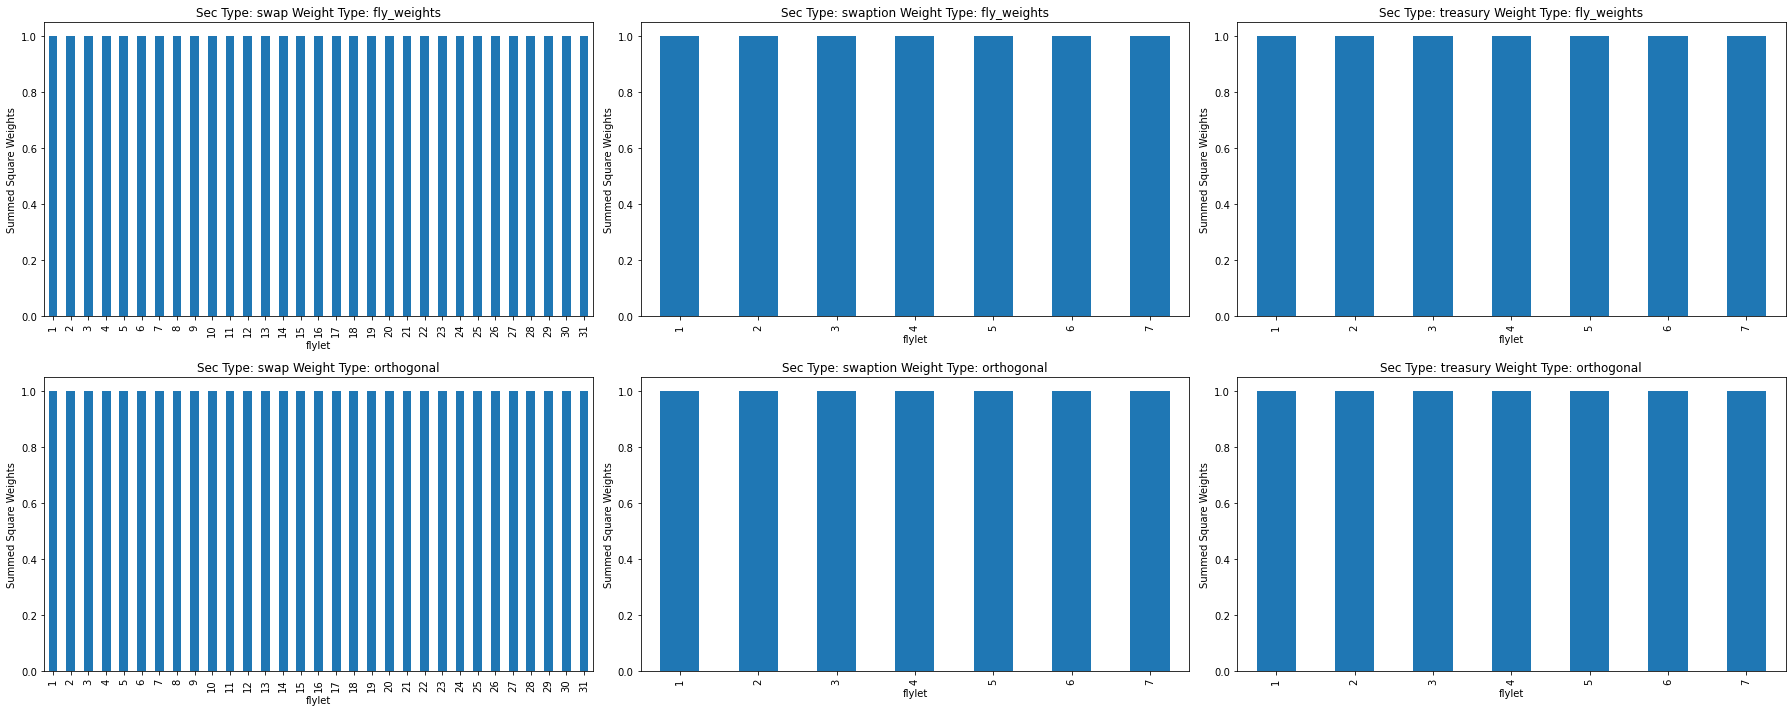

In [20]:
plot_check_norm(df_flylets)
plt.tight_layout()

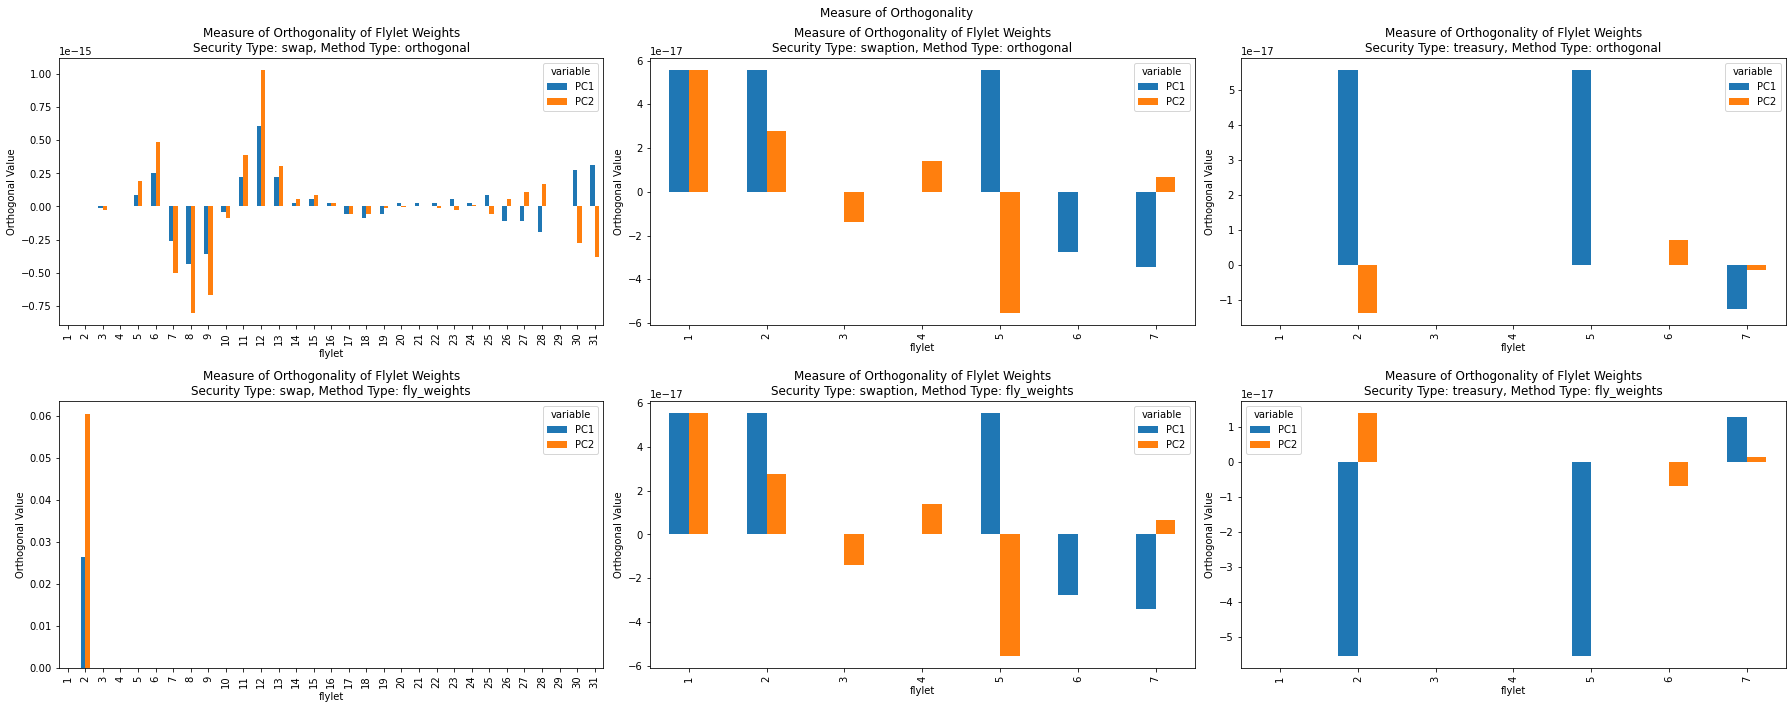

In [21]:
plot_ortho_check(df_flylets)
plt.tight_layout()

# Analyzing Flylets

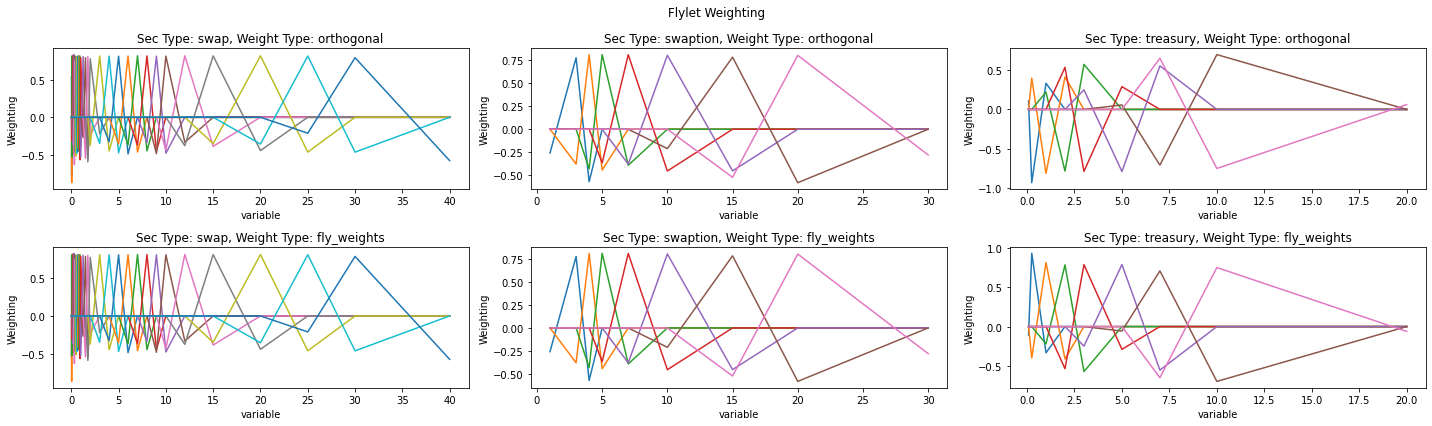

In [72]:
def plot_flylet_weights(df: pd.DataFrame): 

    df_flylets = df.query("flylet != ['PC1', 'PC2']")

    sec_types = df_flylets.sec_type.drop_duplicates().to_list()
    weight_types = df_flylets.weight.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(sec_types), nrows = len(weight_types), figsize = (20,6))
    
    for i, sec_type in enumerate(sec_types):
        for j, weight_type, in enumerate(weight_types):

            (df_flylets.query(
                "sec_type == @sec_type & weight == @weight_type").
                drop(columns = ["sec_type", "weight"]).
                pivot(index = "flylet", columns = "variable", values = "value").
                fillna(0).
                reset_index().
                assign(flylet = lambda x: x.flylet.str.replace("flylet", "").astype(int)).
                set_index("flylet").
                sort_index().
                T.
                plot(
                    legend = False,
                    ax = axes[j,i],
                    ylabel = "Weighting",
                    title = "Sec Type: {}, Weight Type: {}".format(sec_type, weight_type)))
    
    fig.suptitle("Flylet Weighting")

plot_flylet_weights(df_flylets)
plt.tight_layout()

# Analyzing Flylet Volatility